<a href="https://colab.research.google.com/github/Gusa01/spotify-song-analysis-and-popularity-prediction/blob/main/spotify_song_analysis_%26_popularity_prediction_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.decomposition import PCA
from hyperopt import fmin, tpe, hp, Trials
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

In [ ]:
path = 'https://drive.google.com/uc?id=1Cr-pBy78hWeAfoDqmO1wPhoqjwOsTn6M'
pd.set_option('display.max_columns', 50)
df = pd.read_csv(path, encoding= 'unicode_escape')

# Analytical Context

In this section, I will comment on some aspects regarding the dataset:

Although it was obtained from Kaggle, the data source is the Spotify API.
This dataset displays characteristics of songs, and below, I will indicate what some of its fields represent:
- Instrumentalness: This value represents the amount of vocals in the song. The closer this value is to 1.0, the more instrumental the song is likely to be.
- Acousticness: This value describes how acoustic the song is. If the score is close to 1, the song is very likely to be acoustic.
- Liveness: This value describes the probability that the song was recorded live. If this score is higher than 0.8, it is very likely to be a live recording.
- Valence: This value describes the vibe of the songs. Values close to 1.0 indicate more positive songs, while values closer to 0 tend to sound more negative.
- Energy: This value represents the activity and/or intensity in the songs. Songs with high energy are usually faster and louder.
- Danceability: This value describes how suitable the song is for dancing based on elements such as tempo, rhythmic stability, beat strength, and, above all, regularity. The closer to 1.0, the more danceable the song is.
In terms of size, this dataset consists of 18 columns and 50005 records.






# Business problem and objective

In the present day, in 2023, releasing a song and giving people the opportunity to listen to it is much simpler compared to 30 years ago. This is largely thanks to platforms like Spotify, not only for the easy access it provides to any type of auditory content, be it songs or podcasts, but also due to the vast user traffic it manages. However, even with all this, it's not always easy for songs to achieve the level of popularity their creators would like. The reality is, which artist wouldn't want to know if their song will be successful—whether all the time and money invested will be worthwhile? My goal is to develop a solution that addresses this concern.

To achieve this, the idea is to classify a song based on a set of data extracted from Spotify, determining whether its popularity could be above the average (a value that can be observed in the EDA through a popularity histogram). This involves considering features such as its dominant note, danceability, energy, loudness, tempo, etc. For this initial phase, we will explore several questions related to these data:

- What are the most popular genres?
- Can we identify any patterns regarding the tempo of songs?
- Is there a clear relationship between the popularity of songs and characteristics such as energy or danceability?

# Exploratory Data Analysis (EDA)

In [ ]:
# Cleaning and modifying the data
df.tempo = df.tempo.replace('?', np.NaN)
df.tempo = df.tempo.astype(float)
df.speechiness = df.speechiness.astype(float)
df.energy = df.energy * 100
df.danceability = df.danceability * 100
df_normalized = df.applymap(lambda x: x.encode('iso-8859-1').decode('utf-8') if isinstance(x, str) else x)
# Creation of categorical column to group according to tempo
bins = [0, 60, 66, 76, 108, 120, 168, 200, 216]
labels = ['Lento', 'Larghetto', 'Adagio', 'Andante', 'Moderato', 'Allegro', 'Presto', 'Prestissimo']
df_normalized['tempo_type'] = pd.cut(df_normalized['tempo'], bins=bins, labels=labels)

df_norma_sample = df_normalized.sample(2000)

Text(0.5, 1.0, 'Energy x Popularity')

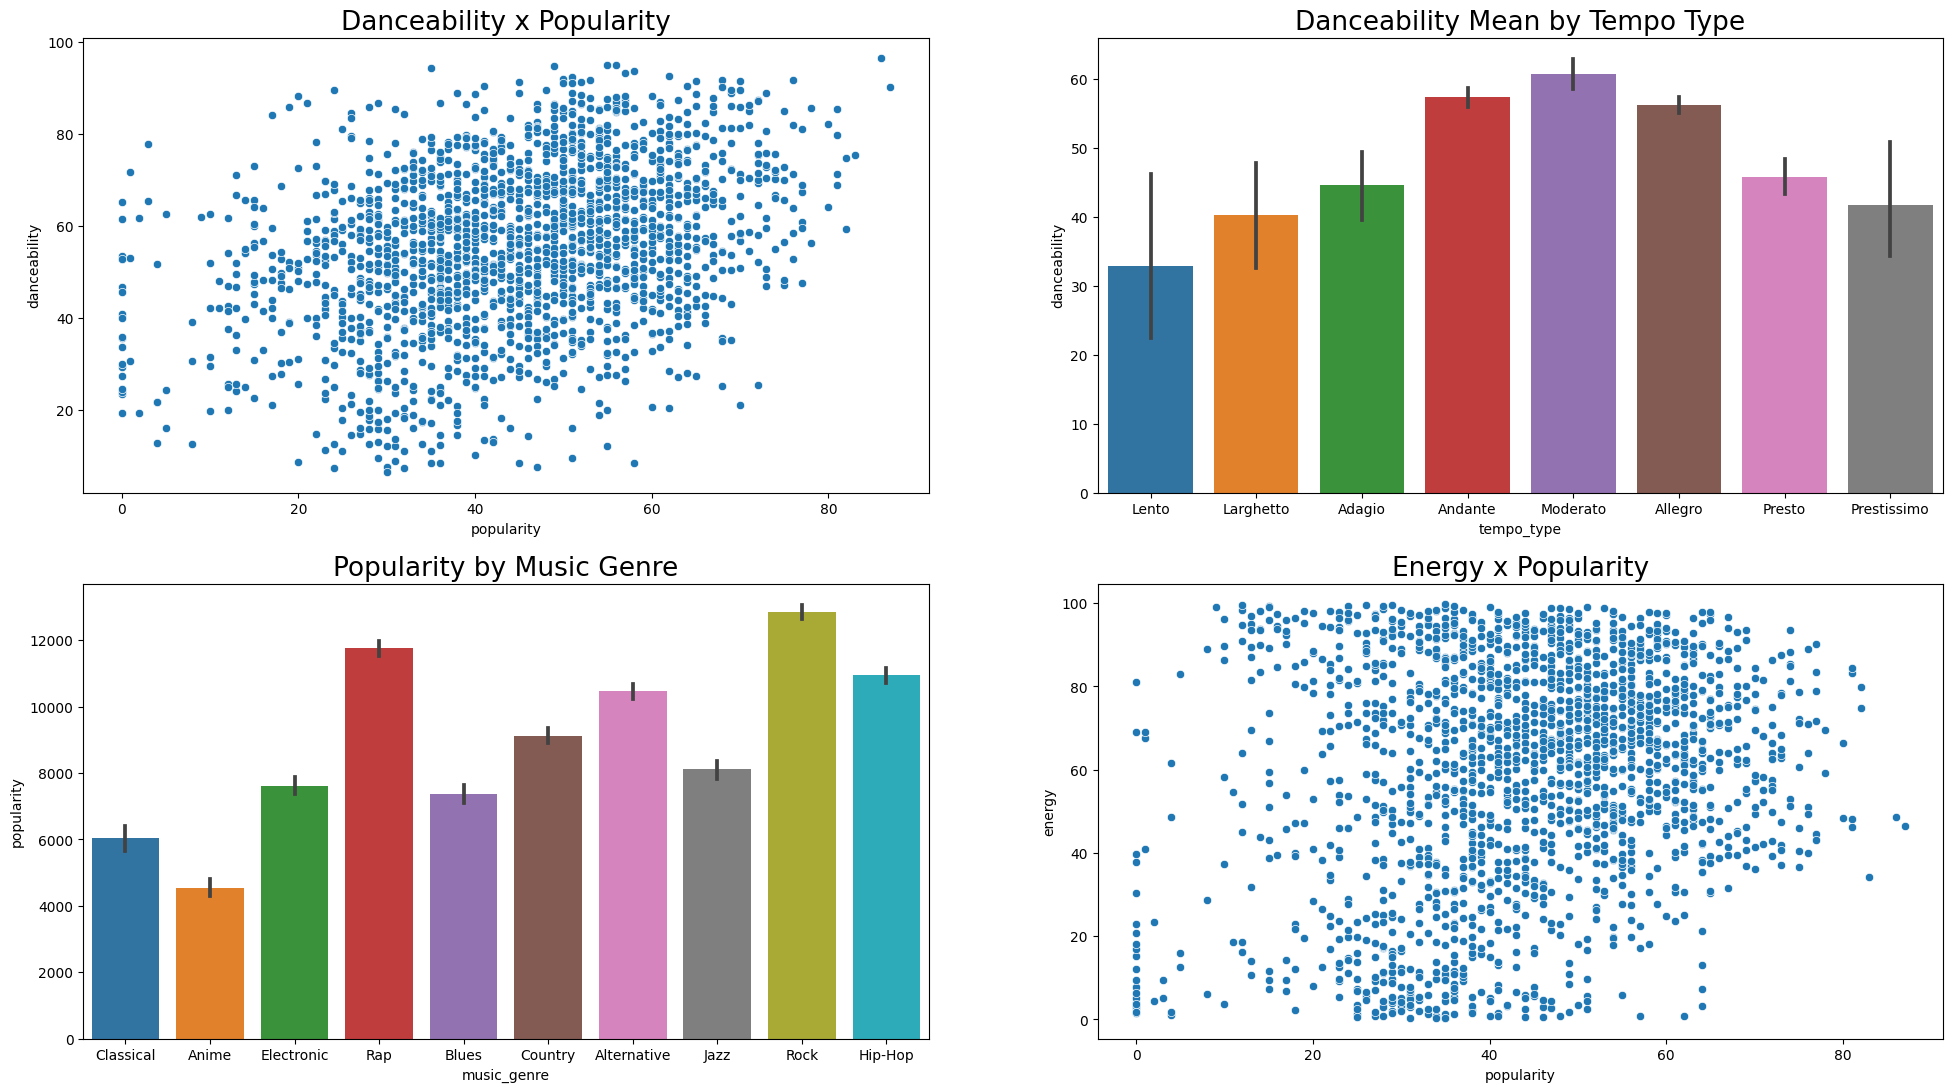

In [ ]:
# Charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 13))
sns.scatterplot(x = df_norma_sample.popularity, y= df_norma_sample.danceability, ax= axes[0,0])
axes[0,0].set_title('Danceability x Popularity', fontsize= 19)
sns.barplot(data= df_norma_sample, x= 'tempo_type', y= 'danceability', estimator= np.mean, ax= axes[0,1])
axes[0,1].set_title('Danceability Mean by Tempo Type', fontsize= 19)
sns.barplot(data = df_norma_sample, x= 'music_genre', y= 'popularity', estimator= sum, ax= axes[1,0])
axes[1,0].set_title('Popularity by Music Genre', fontsize= 19)
sns.scatterplot(x = df_norma_sample.popularity, y= df_norma_sample.energy, ax= axes[1,1])
axes[1,1].set_title('Energy x Popularity', fontsize= 19)

Text(0.5, 1.0, 'Loudness for Songs with More than 50 Popularity')

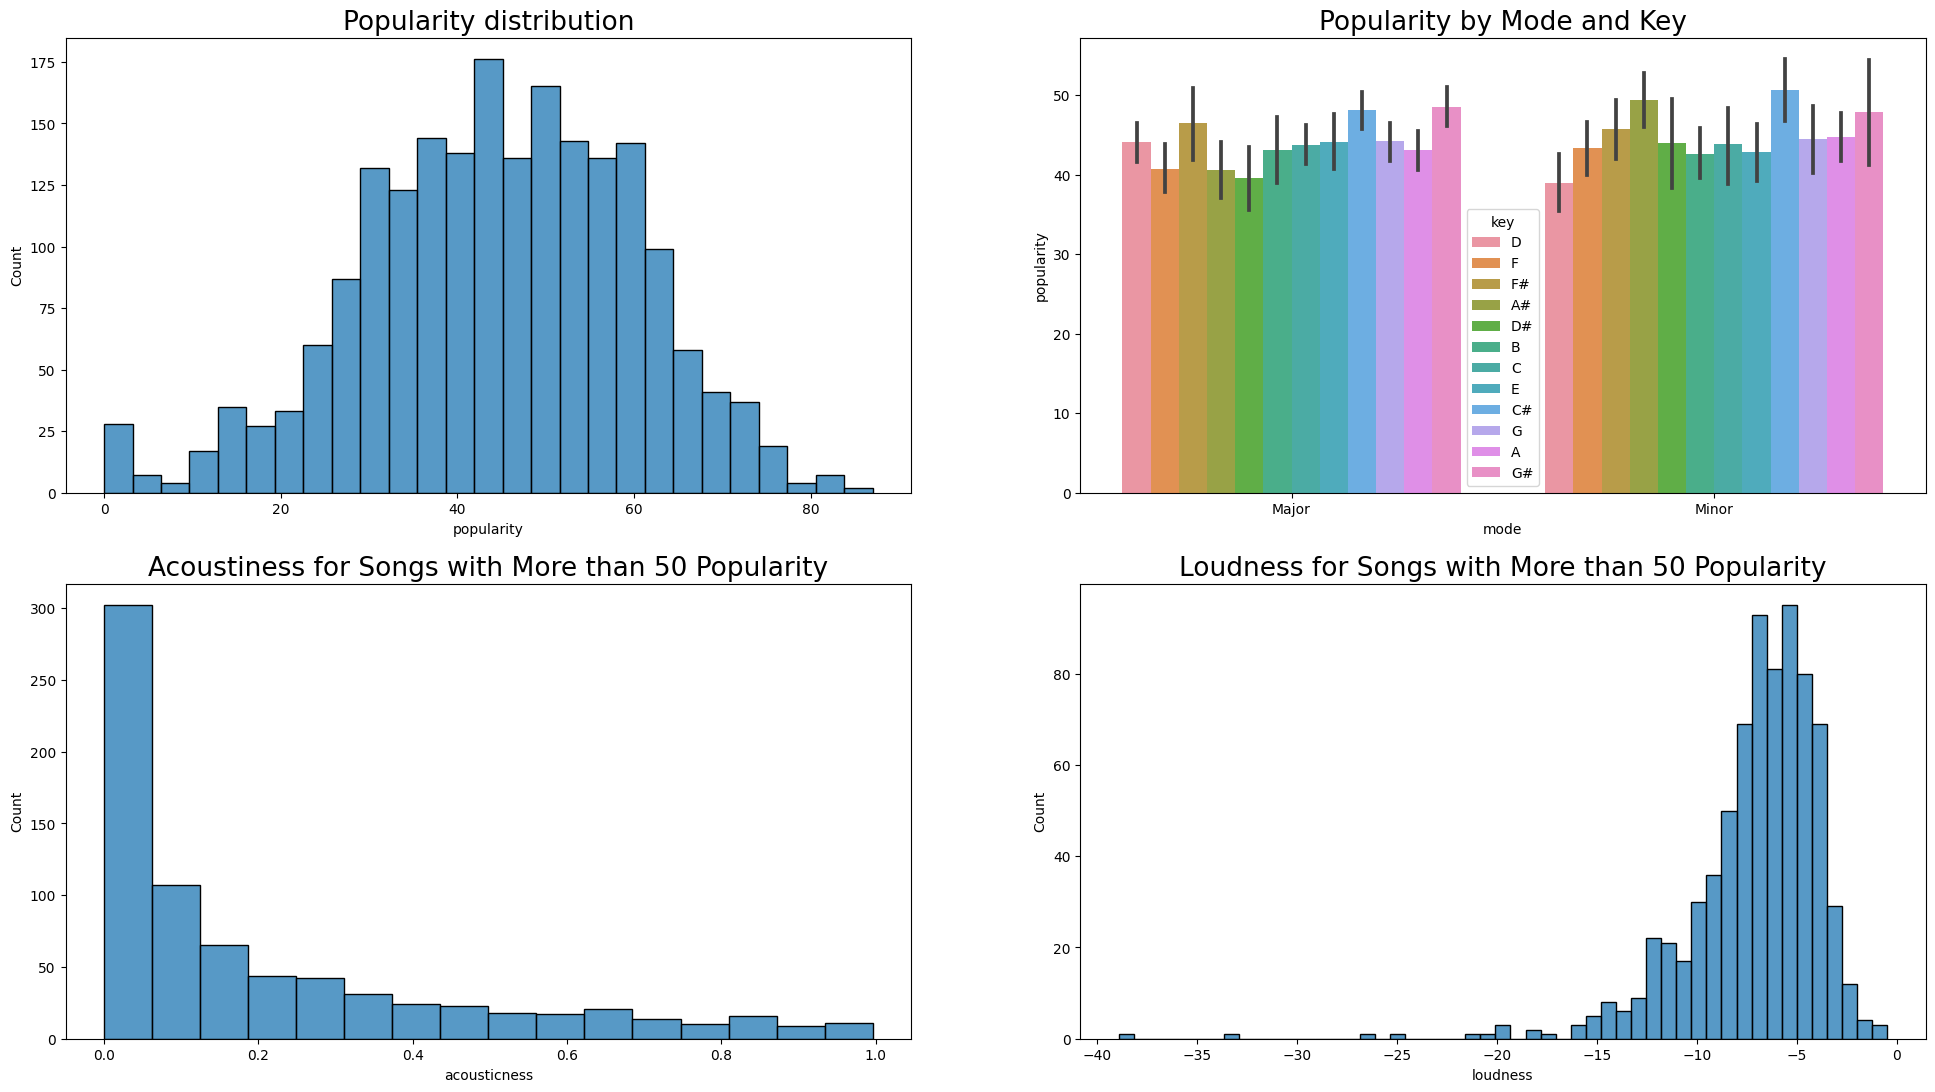

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 13))
sns.histplot(df_norma_sample['popularity'], ax=axes[0,0])
axes[0,0].set_title('Popularity distribution', fontsize= 19)
sns.barplot(x = 'mode', y = 'popularity', hue = 'key', data = df_norma_sample, ax=axes[0,1])
axes[0,1].set_title('Popularity by Mode and Key', fontsize= 19)
popular_above_50 = df_norma_sample[df_norma_sample.popularity > 50]
sns.histplot(popular_above_50['acousticness'], ax=axes[1,0])
axes[1,0].set_title('Acoustiness for Songs with More than 50 Popularity', fontsize= 19)
sns.histplot(popular_above_50['loudness'], ax=axes[1,1])
axes[1,1].set_title('Loudness for Songs with More than 50 Popularity', fontsize= 19)

After examining these graphs, we can draw several conclusions to address the earlier questions:

- The top 3 genres in terms of popularity are Hip-hop, Rock, and Rap.
- Grouping tempo by types reveals that more danceable songs tend to have a tempo classified as andante, moderato, or allegro, indicating that danceable tempos typically range between 76 and 168 BPM.
- Scatter plots show no clear pattern between energy, danceability, and the popularity of songs. Thus, we can infer that there is not a significant correlation between these variables.
- No particular combination stands out prominently when it comes to mode and tonic note.
- Songs with a popularity score above 50 often exhibit a low level of acousticness, suggesting a potential higher correlation with popularity compared to other variables.
- Similarly, the "Loudness" variable is more frequently present in popular songs, typically within a range of approximately -11 to 0.

Having gained a better understanding of the data, we can now delve into preprocessing to achieve a transformation that optimally enhances the performance of a Machine Learning model. Based on this analysis, we can specifically emphasize the importance of the genre, which we will exclude during model training. This decision is made to prevent the model from being overly influenced by the genre variable. The goal is not to push artists toward a particular musical genre but to focus on the musical values of the song that they can adjust within their preferences. This approach aims to enhance the popularity of their songs without confining them to specific genres.

# Data preprocessing

In [ ]:
# Reloading the df to avoid mistakes
path = 'https://drive.google.com/uc?id=1Cr-pBy78hWeAfoDqmO1wPhoqjwOsTn6M'
pd.set_option('display.max_columns', 50)
df = pd.read_csv(path, encoding= 'unicode_escape')

In [ ]:
# Cleaning and modifying the data
df.tempo = df.tempo.replace('?', np.NaN)
df.tempo = df.tempo.astype(float)
df.speechiness = df.speechiness.astype(float)
# Binary Enconding for Mode column
df.loc[df["mode"] == 'Major', "mode"] = 1
df.loc[df["mode"] == 'Minor', "mode"] = 0
# Binary Encoding for Popularity, grouping by whether or not it exceeds the peak in the value distribution, which is 57
df.loc[df['popularity'] < 57, 'popularity'] = 0
df.loc[df['popularity'] >= 57, 'popularity'] = 1
df.loc[df['popularity'] == 1]
# One hot encoding for Key variable
list_of_keys = df['key'].unique()
for i in range(len(list_of_keys)):
    df.loc[df['key'] == list_of_keys[i], 'key'] = i
df.sample(5)

# UTF-8 encoding using an ApplyMap to see special characters
df_normalized = df.applymap(lambda x: x.encode('iso-8859-1').decode('utf-8') if isinstance(x, str) else x)
df_normalized.drop_duplicates()

# Removing outliers using the IQR method
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    df = df[(df[column_name] > lower_limit) & (df[column_name] < upper_limit)].copy()

    return df

cols = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence',]

for col in cols:
  remove_outliers(df_normalized, col)

In [ ]:
df_normalized = df_normalized.replace('NA', np.nan)
df_normalized = df_normalized.replace('nan', np.nan)

# I understand that there are 5 records that have null in all the columns so I try to delete them and check again
df_normalized = df_normalized.dropna(how='all')

# Imputation of numerical columns using the mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
imputer_mean = SimpleImputer(strategy='mean')
df_normalized[numeric_columns] = imputer_mean.fit_transform(df_normalized[numeric_columns])

#Imputation of categorical columns using mode
categorical_columns = df.select_dtypes(include=['object']).columns
imputer_mode = SimpleImputer(strategy='most_frequent')
df_normalized[categorical_columns] = imputer_mode.fit_transform(df_normalized[categorical_columns])

df_normalized.isnull().sum()

# Training and optimization of ML models

In this section, I will utilize "df_normalized" to train classification models such as:

- Logistic Regression
- Random Forest
- Decision Trees
- K-Nearest Neighbors

Subsequently, I will compare them using metrics like Accuracy, AUC, and F1-Score to determine the best-performing model. If needed, I will optimize their hyperparameters to enhance overall performance.

In [ ]:
# Logistic Regression
X = df_normalized.drop(['popularity', 'instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = df_normalized['popularity']

LR_Model = LogisticRegression()
scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc', 'f1': 'f1'}
results = cross_validate(LR_Model, X, y, scoring=scoring)

accuracies = results['test_accuracy']
auc_scores = results['test_auc']
f1_scores = results['test_f1']

for fold, (accuracy, auc_score, f1_score) in enumerate(zip(accuracies, auc_scores, f1_scores), start=1):
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"F1-Score: {f1_score:.4f}\n")

lr_accuracy_mean = np.mean(accuracies)
lr_auc_scores_mean = np.mean(auc_scores)
lr_f1_scores_mean = np.mean(f1_scores)

In [ ]:
#Arboles de Decisión
X = df_normalized.drop(['popularity', 'instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = df_normalized['popularity']

DT_Model = DecisionTreeClassifier()
scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc', 'f1': 'f1'}
results = cross_validate(DT_Model, X, y, scoring=scoring)

accuracies = results['test_accuracy']
auc_scores = results['test_auc']
f1_scores = results['test_f1']

for fold, (accuracy, auc_score, f1_score) in enumerate(zip(accuracies, auc_scores, f1_scores), start=1):
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"F1-Score: {f1_score:.4f}\n")

dt_accuracy_mean = np.mean(accuracies)
dt_auc_scores_mean = np.mean(auc_scores)
dt_f1_scores_mean = np.mean(f1_scores)

In [ ]:
#Random Forest
X = df_normalized.drop(['popularity', 'instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = df_normalized['popularity']

RFC_Model = RandomForestClassifier()
scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc', 'f1': 'f1'}
results = cross_validate(RFC_Model, X, y, scoring=scoring)

accuracies = results['test_accuracy']
auc_scores = results['test_auc']
f1_scores = results['test_f1']

for fold, (accuracy, auc_score, f1_score) in enumerate(zip(accuracies, auc_scores, f1_scores), start=1):
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"F1-Score: {f1_score:.4f}\n")

rf_accuracy_mean = np.mean(accuracies)
rf_auc_scores_mean = np.mean(auc_scores)
rf_f1_scores_mean = np.mean(f1_scores)

In [ ]:
#KNN
X = df_normalized.drop(['popularity', 'instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = df_normalized['popularity']

KNN_Model = KNeighborsClassifier()
scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc', 'f1': 'f1'}
results = cross_validate(KNN_Model, X, y, scoring=scoring)

accuracies = results['test_accuracy']
auc_scores = results['test_auc']
f1_scores = results['test_f1']

for fold, (accuracy, auc_score, f1_score) in enumerate(zip(accuracies, auc_scores, f1_scores), start=1):
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"F1-Score: {f1_score:.4f}\n")

knn_accuracy_mean = np.mean(accuracies)
knn_auc_scores_mean = np.mean(auc_scores)
knn_f1_scores_mean = np.mean(f1_scores)

In [ ]:
# Summary table
results_df = pd.DataFrame(columns=['Modelo', 'Promedio Accuracy', 'Promedio AUC', 'Promedio F1-Score'])

results_df.loc[0] = ['Decision Tree', dt_accuracy_mean, dt_auc_scores_mean, dt_f1_scores_mean]
results_df.loc[1] = ['Random Forest', rf_accuracy_mean, rf_auc_scores_mean, rf_f1_scores_mean]
results_df.loc[2] = ['Logistic Regression', lr_accuracy_mean, lr_auc_scores_mean, lr_f1_scores_mean]
results_df.loc[3] = ['KNN', knn_accuracy_mean,knn_auc_scores_mean, knn_f1_scores_mean]

results_df = results_df.sort_values(by = "Promedio Accuracy", ascending = False)
results_df

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 50),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1)
}


def objective(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    return -np.mean(scores)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

best_n_estimators = int(best['n_estimators'])
best_max_depth = int(best['max_depth'])
best_min_samples_split = int(best['min_samples_split'])

print("Mejores hiperparámetros:")
print(f"n_estimators: {best_n_estimators}")
print(f"max_depth: {best_max_depth}")
print(f"min_samples_split: {best_min_samples_split}")

100%|██████████| 50/50 [1:31:30<00:00, 109.81s/trial, best loss: -0.42039334212603174]
Mejores hiperparámetros:
n_estimators: 200
max_depth: 20
min_samples_split: 2


Code output after a 1.5-hour optimization process:

100%|██████████| 50/50 [1:31:30<00:00, 109.81s/trial, best loss: -0.42039334212603174]

Best Hyperparameters:
n_estimators: 200
max_depth: 20
min_samples_split: 2

In this snippet, the code indicates the completion of a 1.5-hour optimization process with 50 iterations. The best hyperparameters found during this process are n_estimators: 200, max_depth: 20, and min_samples_split: 2. These hyperparameters represent the configurations that maximize or minimize the evaluation metric

In [ ]:
#Random Forest with optimized hyperparameters
X = df_normalized.drop(['popularity', 'instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'], axis=1)
y = df_normalized['popularity']

RFC_Model = RandomForestClassifier(n_estimators= 200, max_depth= 20, min_samples_split= 2)
scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc', 'f1': 'f1'}
results = cross_validate(RFC_Model, X, y, scoring=scoring)

accuracies = results['test_accuracy']
auc_scores = results['test_auc']
f1_scores = results['test_f1']

rf_accuracy_mean = np.mean(accuracies)
rf_auc_scores_mean = np.mean(auc_scores)
rf_f1_scores_mean = np.mean(f1_scores)
print('Accuracy:', rf_accuracy_mean,
      'AUC:', rf_auc_scores_mean,
      'F1-Score:', rf_f1_scores_mean)

Accuracy: 0.8001800000000001 AUC: 0.7480141156963959 F1-Score: 0.4338423186281462
